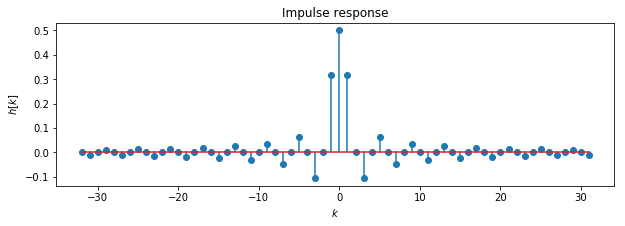

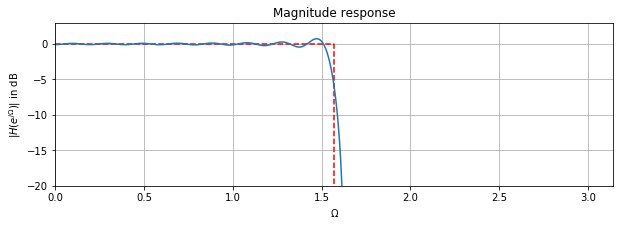

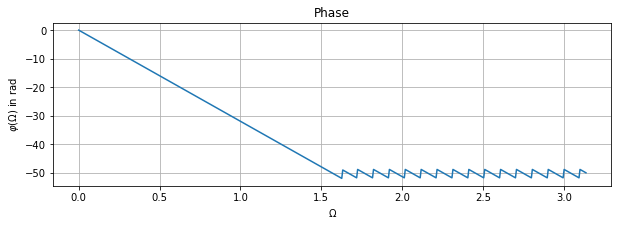

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig


# . Exemple de filtre "en sinus cardinal"
# . Et exemple de tracé de réponse impulsionnelle et fréquentielle
N = 32           # Longueur du filtre (=ordre du filtre - 1)
Omc = np.pi/2    # Fréquence de coupure

# Calcul de la réponse impulsionnelle
k = np.arange(-N,N)
hd = Omc/np.pi * np.sinc(k*Omc/np.pi)
# windowing
w = np.ones(2*N)
h = hd * w

# Réponse fréquentielle (entre 0 et pi)
Om, H = sig.freqz(h)

# tracé de la réponse impulsionnelle
plt.figure(figsize=(10, 3))
plt.stem(k,h)
plt.title('Impulse response')
plt.xlabel(r'$k$')
plt.ylabel(r'$h[k]$')


# tracé de la réponse fréquentielle en amplitude et en dB
plt.figure(figsize=(10, 3))
plt.plot([0, Omc, Omc], [0, 0, -100], 'r--')
plt.plot(Om, 20 * np.log10(abs(H)))
plt.title('Magnitude response')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
plt.axis([0, np.pi, -20, 3])
plt.grid()


# tracé de la réponse fréquentielle en phase
plt.figure(figsize=(10, 3))
plt.plot(Om, np.unwrap(np.angle(H)))
plt.title('Phase')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\varphi (\Omega)$ in rad')
plt.grid()

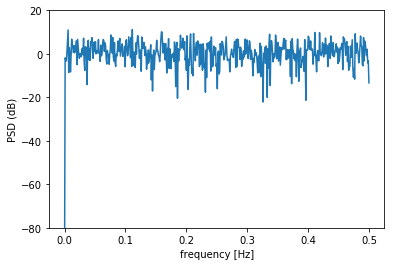

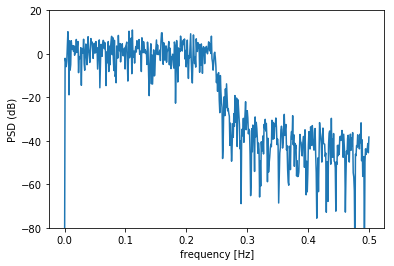

In [27]:
L=1024
IN = np.random.standard_normal(L)
OUT = sig.convolve(h,IN)

f, Pin = sig.periodogram(IN, 1)
plt.plot(f, 10*np.log10(Pin+1e-10))
plt.ylim([-80, 20])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD (dB)')
plt.show()
f, Pout = sig.periodogram(OUT, 1)
plt.plot(f, 10*np.log10(Pout+1e-10))
plt.ylim([-80, 20])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD (dB)')
plt.show()


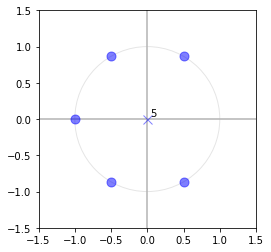

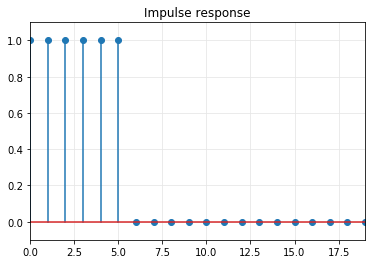

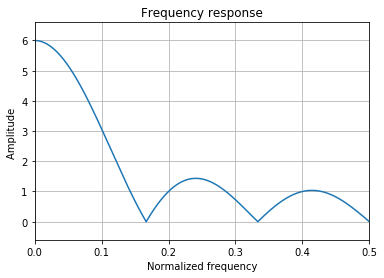

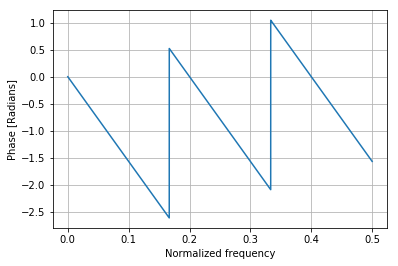

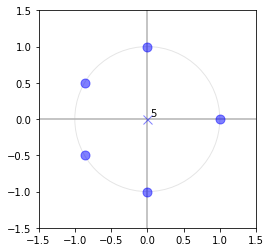

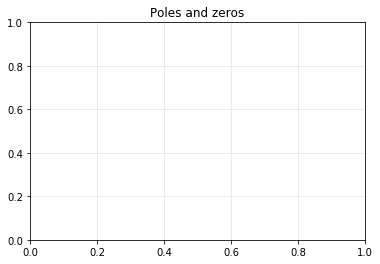

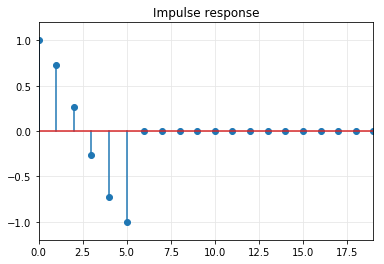

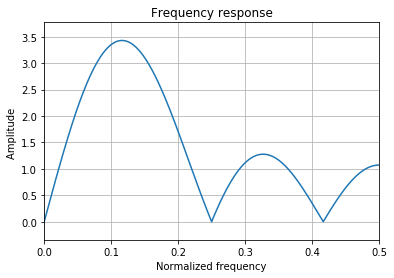

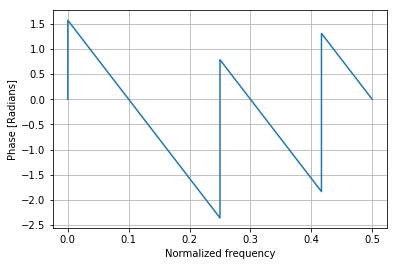

In [31]:
# . Tracé de zéros - poles - réponse impulsionnelle - réponses fréquentielles
#   à partir des zéros et poles
# . adaptable à une fonction de transfert (en z) en vous référant à 
#   https://docs.scipy.org/doc/scipy/reference/signal.html
# .  signal.TransferFunction(num, den)
# .  et signal.to_zpk()



# -*- coding: utf-8 -*-
"""
Combination of
http://scipy-central.org/item/52/1/zplane-function
and
http://www.dsprelated.com/showcode/244.php
with my own modifications
"""

# Copyright (c) 2011 Christopher Felton
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even thpwde implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.


# The following is derived from the slides presented by
# Alexander Kain for CS506/606 "Special Topics: Speech Signal Processing"
# CSLU / OHSU, Spring Term 2011.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.pyplot import axvline, axhline
from collections import defaultdict
from scipy import signal
from scipy.signal import (freqz, butter, bessel, cheby1, cheby2, ellip,
                          tf2zpk, zpk2tf, lfilter, buttap, bilinear, cheb2ord, cheb2ap
                          )
from numpy import asarray, tan, array, pi, arange, cos, log10, unwrap, angle
from matplotlib.pyplot import (stem, title, grid, show, plot, xlabel,
                              ylabel, subplot, xscale, figure, xlim,margins)




def detmult(z):
    s=np.size(z)
    mark=np.zeros(s)
    i=0
    inter=(np.abs(z-z[i])<1e-5)*1.0
    multinter=np.sum(inter)
    mark=mark+inter*multinter
    mult=[[z[i],int(multinter)]]
    
    while i < s :
        i=i+1
        if (i<s) and (mark[i]==0):
            inter=(np.abs(z-z[i])<1e-5)*1.0
            multinter=np.sum(inter)
            mark=mark+inter*multinter
            mult=np.concatenate((mult,[[z[i],int(multinter)]]))
        
    
    return np.array(mult)
    
def zplane(z, p, ax,filename=None):
    """Plot the complex z-plane given zeros and poles.
    """

 
    unit_circle = patches.Circle((0,0), radius=1, fill=False,
                                 color='black', ls='solid', alpha=0.1)
    ax.add_patch(unit_circle)
    axvline(0, color='0.7')
    axhline(0, color='0.7')

    # Scale axes to fit
    r = 1.5 * np.amax(np.concatenate((np.abs(z), np.abs(p), [1])))
    plt.axis('scaled')
    plt.axis([-r, r, -r, r])
    multz=detmult(z)
    multp=detmult(p)
    nz,throw=multz.shape
    npo,throw=multp.shape
    for i in np.arange(nz):
        plt.plot(multz[i,0].real,multz[i,0].imag,'o',markersize=9,
                 color='b',alpha=0.5)
        if multz[i,1]>1:
            plt.text(multz[i,0].real+r*0.03,multz[i,0].imag+r*0.03,int(multz[i,1]))
    for i in np.arange(npo):
        plt.plot(multp[i,0].real,multp[i,0].imag,'x',markersize=9,
                 color='b',alpha=0.5)
        if multp[i,1]>1:
            plt.text(multp[i,0].real+r*0.03,multp[i,0].imag+r*0.03,int(multp[i,1]))
    
    
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
        print('Pole-zero plot saved to ' + str(filename))

def figfile(exo,fignum):
    n=fignum//4;
    typ=['zpoles','repimp','repfreq','phase']
    name='../TNSFIGURES/tnsfig_exo_7'+str(exo)+'_'+typ[fignum%4]+'.pdf'
    return name

def sysplots(z,p,gain,nimp,numfig=0):

    sys=signal.ZerosPolesGain(z, p, gain, dt=1)
    
    # Create zero-pole plot
    f=plt.figure(numfig)
    plt.clf()
    ax=plt.subplot(1, 1, 1)
    zplane(z, p,ax)
    grid(True, color='0.9', linestyle='-', which='both', axis='both')
    title('Poles and zeros')
    
    #f.savefig(figfile(1,numfig), bbox_inches='tight')

    
    
    # Impulse response
    f=plt.figure(numfig+1)
    plt.clf()
    index,y = signal.dimpulse(sys,n=nimp)
    stem(index,y[0])
    title('Impulse response')
    margins(0, 0.1)
    grid(True, color='0.9', linestyle='-', which='both', axis='both')
    show()
    #f.savefig(figfile(1,numfig), bbox_inches='tight')

    # Frequency response
    f=plt.figure(numfig+2)
    plt.clf()
    w, h = signal.dfreqresp(sys)
    plot(w/pi/2, abs(h))
    
    title('Frequency response')
    xlabel('Normalized frequency')
    ylabel('Amplitude ')
    margins(0, 0.1)
    grid(True, color = '0.7', linestyle='-', which='major', axis='both')
    grid(True, color = '0.9', linestyle='-', which='minor', axis='both')
    show()
    #f.savefig(figfile(1,numfig), bbox_inches='tight')
    
    # Phase
    f=plt.figure(numfig+3)
    plt.clf()
    plot(w/pi/2,  unwrap(angle(h)))
    xlabel('Normalized frequency')
    ylabel('Phase [Radians]')
    grid(True, color = '0.7', linestyle='-', which='major')
    grid(True, color = '0.9', linestyle='-', which='minor')
    show()
    #f.savefig(figfile(1,numfig), bbox_inches='tight')

                             

#    # Cosine function
#    omega = pi/4
#    b = array([1.0, -cos(omega)])
#    a = array([1, -2*cos(omega), 1.0])


zp=[]
zp=[[[-1,np.exp(1j*2*np.pi/6),np.exp(-1j*2*np.pi/6),np.exp(1j*4*np.pi/6),
      np.exp(-1j*4*np.pi/6)],[0,0,0,0,0],[20]]]
zp=zp+[[[1, 1j, -1j, np.exp(1j*5*np.pi/6),np.exp(-1j*5*np.pi/6)],[0,0,0,0,0],[20]]]


nzp,throwz=np.shape(zp)

for nsys in np.arange(nzp):
    sysplots(np.array(zp[nsys][0]),np.array(zp[nsys][1]),1,zp[nsys][2][0],nsys*4)


